In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

from dataset import MyDataset, built_attr2label, imshow, ATTR_FOR_CLASSIFY
from trainer import load_model, save_model, train_model
from CyclicLR import CyclicLR

## dataset

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(10, resample=Image.BILINEAR, expand=True),
        transforms.Resize((230, 230)),  # 224 for resnet and densenet
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # mean, std
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
root = '../datasets/imaterialist/'
train_csv = os.path.join(root, 'attribute_label', 'for_classify_train.csv')
val_csv = os.path.join(root, 'attribute_label', 'for_classify_val.csv')

In [4]:
batch_sizes = {"train":48, "val":48}
train_dataset = MyDataset(root, train_csv, ATTR_FOR_CLASSIFY, transform=data_transforms["train"], use_jitter=False)
val_dataset = MyDataset(root, val_csv, ATTR_FOR_CLASSIFY, transform=data_transforms["val"])
image_datasets = {"train":train_dataset, "val":val_dataset}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_sizes[x],
                                             shuffle=(x=="train"), num_workers=3, drop_last=(x=="train"))
              for x in ["train", "val"]}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
dataloaders['size'] = dataset_sizes
# class_names = image_datasets["train"].classes
# print(class_names)

use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [5]:
# val_iter = iter(dataloaders['train'])

In [6]:
# # Get a batch of training data
# inputs, classes = next(val_iter)
# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out)#, title=[class_names[x] for x in classes]
# # plt.imshow(out, title=[class_names[x] for x in classes])

## model

In [7]:
attr2label = built_attr2label(ATTR_FOR_CLASSIFY)

num_out = 0
label_index = [0]
for key in attr2label.keys():
    num_out += len(attr2label[key])
    label_index.append(num_out)
num_out

106

In [8]:
model = load_model(num_out)

## training

In [9]:
# criterion = nn.CrossEntropyLoss()
criterions = [nn.CrossEntropyLoss() for _ in attr2label.keys()]

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
# optimizer_ft = optim.Adam(model.parameters())
# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

step_size = 2 * (dataset_sizes['train'] / batch_sizes['train'])
lr_scheduler = CyclicLR(optimizer_ft, base_lr=0.0001, max_lr=0.008, mode='triangular2', step_size=step_size) # 4 epochs 1 cycle

In [10]:
save_dir = '../train_logs/garment_attribute_classify/res50_edge/'
model_ft = train_model(dataloaders, model, criterions, optimizer_ft, lr_scheduler, label_index, 
                       num_epochs=35, save_freq=5, count_loss_weight=0, save_dir=save_dir)

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch 0/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.9862, Count Loss: 0.0000, Acc: 0.6633, Global Acc: 0.0061


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.7706, Count Loss: 0.0000, Acc: 0.7406, Global Acc: 0.0167

Epoch 1/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.7147, Count Loss: 0.0000, Acc: 0.7581, Global Acc: 0.0223


100%|██████████| 37/37 [02:43<00:00,  4.43s/it]


val Loss: 0.6620, Count Loss: 0.0000, Acc: 0.7728, Global Acc: 0.0329


  0%|          | 0/204 [00:00<?, ?it/s]


Epoch 2/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.6262, Count Loss: 0.0000, Acc: 0.7850, Global Acc: 0.0446


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.6109, Count Loss: 0.0000, Acc: 0.7854, Global Acc: 0.0421

Epoch 3/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.5821, Count Loss: 0.0000, Acc: 0.7989, Global Acc: 0.0621


100%|██████████| 37/37 [02:43<00:00,  4.42s/it]


val Loss: 0.5957, Count Loss: 0.0000, Acc: 0.7898, Global Acc: 0.0409


  0%|          | 0/204 [00:00<?, ?it/s]


Epoch 4/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.5668, Count Loss: 0.0000, Acc: 0.8040, Global Acc: 0.0671


100%|██████████| 37/37 [02:42<00:00,  4.40s/it]


val Loss: 0.5938, Count Loss: 0.0000, Acc: 0.7913, Global Acc: 0.0479


  0%|          | 0/204 [00:00<?, ?it/s]


Epoch 5/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.5591, Count Loss: 0.0000, Acc: 0.8054, Global Acc: 0.0657


100%|██████████| 37/37 [02:46<00:00,  4.50s/it]


val Loss: 0.5874, Count Loss: 0.0000, Acc: 0.7963, Global Acc: 0.0502


  0%|          | 0/204 [00:00<?, ?it/s]


Epoch 6/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.5415, Count Loss: 0.0000, Acc: 0.8108, Global Acc: 0.0693


100%|██████████| 37/37 [02:42<00:00,  4.39s/it]


val Loss: 0.5761, Count Loss: 0.0000, Acc: 0.7975, Global Acc: 0.0542


  0%|          | 0/204 [00:00<?, ?it/s]


Epoch 7/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.5211, Count Loss: 0.0000, Acc: 0.8183, Global Acc: 0.0822


100%|██████████| 37/37 [02:42<00:00,  4.38s/it]


val Loss: 0.5724, Count Loss: 0.0000, Acc: 0.7991, Global Acc: 0.0542


  0%|          | 0/204 [00:00<?, ?it/s]


Epoch 8/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.5148, Count Loss: 0.0000, Acc: 0.8201, Global Acc: 0.0871


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5748, Count Loss: 0.0000, Acc: 0.7984, Global Acc: 0.0531

Epoch 9/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.5130, Count Loss: 0.0000, Acc: 0.8208, Global Acc: 0.0895


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5779, Count Loss: 0.0000, Acc: 0.7950, Global Acc: 0.0496

Epoch 10/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.5048, Count Loss: 0.0000, Acc: 0.8236, Global Acc: 0.0915


100%|██████████| 37/37 [02:41<00:00,  4.35s/it]


val Loss: 0.5678, Count Loss: 0.0000, Acc: 0.8007, Global Acc: 0.0611


  0%|          | 0/204 [00:00<?, ?it/s]


Epoch 11/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4971, Count Loss: 0.0000, Acc: 0.8258, Global Acc: 0.0922


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5658, Count Loss: 0.0000, Acc: 0.8006, Global Acc: 0.0565

Epoch 12/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4916, Count Loss: 0.0000, Acc: 0.8277, Global Acc: 0.0973


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5680, Count Loss: 0.0000, Acc: 0.8014, Global Acc: 0.0623

Epoch 13/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4895, Count Loss: 0.0000, Acc: 0.8285, Global Acc: 0.0996


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5660, Count Loss: 0.0000, Acc: 0.8004, Global Acc: 0.0588

Epoch 14/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4860, Count Loss: 0.0000, Acc: 0.8290, Global Acc: 0.0996


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5609, Count Loss: 0.0000, Acc: 0.8022, Global Acc: 0.0588

Epoch 15/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4816, Count Loss: 0.0000, Acc: 0.8312, Global Acc: 0.1040


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5627, Count Loss: 0.0000, Acc: 0.8012, Global Acc: 0.0559

Epoch 16/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4782, Count Loss: 0.0000, Acc: 0.8325, Global Acc: 0.1029


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5606, Count Loss: 0.0000, Acc: 0.8022, Global Acc: 0.0525

Epoch 17/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4772, Count Loss: 0.0000, Acc: 0.8322, Global Acc: 0.1051


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5638, Count Loss: 0.0000, Acc: 0.8030, Global Acc: 0.0657

Epoch 18/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4738, Count Loss: 0.0000, Acc: 0.8336, Global Acc: 0.1090


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5598, Count Loss: 0.0000, Acc: 0.8018, Global Acc: 0.0617

Epoch 19/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4723, Count Loss: 0.0000, Acc: 0.8335, Global Acc: 0.1072


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5639, Count Loss: 0.0000, Acc: 0.8017, Global Acc: 0.0646

Epoch 20/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4702, Count Loss: 0.0000, Acc: 0.8347, Global Acc: 0.1056


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5623, Count Loss: 0.0000, Acc: 0.8023, Global Acc: 0.0623

Epoch 21/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4694, Count Loss: 0.0000, Acc: 0.8352, Global Acc: 0.1060


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5634, Count Loss: 0.0000, Acc: 0.8026, Global Acc: 0.0646

Epoch 22/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4681, Count Loss: 0.0000, Acc: 0.8356, Global Acc: 0.1098


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5625, Count Loss: 0.0000, Acc: 0.8029, Global Acc: 0.0606

Epoch 23/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4669, Count Loss: 0.0000, Acc: 0.8356, Global Acc: 0.1095


100%|██████████| 37/37 [02:41<00:00,  4.35s/it]


val Loss: 0.5595, Count Loss: 0.0000, Acc: 0.8035, Global Acc: 0.0652


  0%|          | 0/204 [00:00<?, ?it/s]


Epoch 24/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4659, Count Loss: 0.0000, Acc: 0.8360, Global Acc: 0.1079


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5625, Count Loss: 0.0000, Acc: 0.8020, Global Acc: 0.0588

Epoch 25/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4658, Count Loss: 0.0000, Acc: 0.8366, Global Acc: 0.1092


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5615, Count Loss: 0.0000, Acc: 0.8022, Global Acc: 0.0582

Epoch 26/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4653, Count Loss: 0.0000, Acc: 0.8363, Global Acc: 0.1091


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5619, Count Loss: 0.0000, Acc: 0.8024, Global Acc: 0.0629

Epoch 27/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4624, Count Loss: 0.0000, Acc: 0.8375, Global Acc: 0.1115


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5629, Count Loss: 0.0000, Acc: 0.8024, Global Acc: 0.0640

Epoch 28/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4617, Count Loss: 0.0000, Acc: 0.8374, Global Acc: 0.1101


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5622, Count Loss: 0.0000, Acc: 0.8033, Global Acc: 0.0629

Epoch 29/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4617, Count Loss: 0.0000, Acc: 0.8376, Global Acc: 0.1085


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5599, Count Loss: 0.0000, Acc: 0.8027, Global Acc: 0.0681

Epoch 30/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4616, Count Loss: 0.0000, Acc: 0.8377, Global Acc: 0.1121


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5615, Count Loss: 0.0000, Acc: 0.8019, Global Acc: 0.0594

Epoch 31/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4612, Count Loss: 0.0000, Acc: 0.8378, Global Acc: 0.1137


100%|██████████| 37/37 [02:41<00:00,  4.37s/it]


val Loss: 0.5611, Count Loss: 0.0000, Acc: 0.8036, Global Acc: 0.0606


  0%|          | 0/204 [00:00<?, ?it/s]


Epoch 32/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4593, Count Loss: 0.0000, Acc: 0.8386, Global Acc: 0.1165


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5647, Count Loss: 0.0000, Acc: 0.8004, Global Acc: 0.0606

Epoch 33/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4573, Count Loss: 0.0000, Acc: 0.8394, Global Acc: 0.1165


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5635, Count Loss: 0.0000, Acc: 0.8025, Global Acc: 0.0669

Epoch 34/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4585, Count Loss: 0.0000, Acc: 0.8385, Global Acc: 0.1135


100%|██████████| 37/37 [02:40<00:00,  4.33s/it]

val Loss: 0.5609, Count Loss: 0.0000, Acc: 0.8024, Global Acc: 0.0629

Training complete in 601m 30s
Best val Acc in epoch31: 0.803551


### res50_edge_color

In [10]:
save_dir = '../train_logs/garment_attribute_classify/res50_edge_color/'
model_ft = train_model(dataloaders, model, criterions, optimizer_ft, lr_scheduler, label_index, 
                       num_epochs=35, save_freq=5, count_loss_weight=0, save_dir=save_dir)

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch 0/34
----------


100%|██████████| 204/204 [14:42<00:00,  2.68s/it]


train Loss: 0.9825, Count Loss: 0.0000, Acc: 0.6733, Global Acc: 0.0032


100%|██████████| 37/37 [02:41<00:00,  4.37s/it]


val Loss: 0.7705, Count Loss: 0.0000, Acc: 0.7415, Global Acc: 0.0144


  0%|          | 0/204 [00:00<?, ?it/s]


Epoch 1/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.7200, Count Loss: 0.0000, Acc: 0.7552, Global Acc: 0.0205


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.6552, Count Loss: 0.0000, Acc: 0.7771, Global Acc: 0.0340

Epoch 2/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.6328, Count Loss: 0.0000, Acc: 0.7825, Global Acc: 0.0406


100%|██████████| 37/37 [02:49<00:00,  4.57s/it]


val Loss: 0.6058, Count Loss: 0.0000, Acc: 0.7880, Global Acc: 0.0404


  0%|          | 0/204 [00:00<?, ?it/s]


Epoch 3/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.5897, Count Loss: 0.0000, Acc: 0.7956, Global Acc: 0.0585


100%|██████████| 37/37 [02:41<00:00,  4.36s/it]


val Loss: 0.5915, Count Loss: 0.0000, Acc: 0.7955, Global Acc: 0.0565


  0%|          | 0/204 [00:00<?, ?it/s]


Epoch 4/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.5744, Count Loss: 0.0000, Acc: 0.8012, Global Acc: 0.0590


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5883, Count Loss: 0.0000, Acc: 0.7944, Global Acc: 0.0525

Epoch 5/34
----------


100%|██████████| 204/204 [14:53<00:00,  4.21s/it]


train Loss: 0.5698, Count Loss: 0.0000, Acc: 0.8026, Global Acc: 0.0642


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5896, Count Loss: 0.0000, Acc: 0.7944, Global Acc: 0.0502

Epoch 6/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.5527, Count Loss: 0.0000, Acc: 0.8066, Global Acc: 0.0687


100%|██████████| 37/37 [02:43<00:00,  4.41s/it]


val Loss: 0.5702, Count Loss: 0.0000, Acc: 0.8005, Global Acc: 0.0611


  0%|          | 0/204 [00:00<?, ?it/s]


Epoch 7/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.5338, Count Loss: 0.0000, Acc: 0.8133, Global Acc: 0.0795


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5648, Count Loss: 0.0000, Acc: 0.8021, Global Acc: 0.0606

Epoch 8/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.5264, Count Loss: 0.0000, Acc: 0.8165, Global Acc: 0.0819


100%|██████████| 37/37 [02:46<00:00,  4.51s/it]


val Loss: 0.5641, Count Loss: 0.0000, Acc: 0.8028, Global Acc: 0.0600


  0%|          | 0/204 [00:00<?, ?it/s]


Epoch 9/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.5259, Count Loss: 0.0000, Acc: 0.8159, Global Acc: 0.0797


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5659, Count Loss: 0.0000, Acc: 0.8007, Global Acc: 0.0600

Epoch 10/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.5154, Count Loss: 0.0000, Acc: 0.8190, Global Acc: 0.0827


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5579, Count Loss: 0.0000, Acc: 0.8040, Global Acc: 0.0623

Epoch 11/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.5092, Count Loss: 0.0000, Acc: 0.8209, Global Acc: 0.0895


100%|██████████| 37/37 [02:44<00:00,  4.46s/it]


val Loss: 0.5567, Count Loss: 0.0000, Acc: 0.8045, Global Acc: 0.0629


  0%|          | 0/204 [00:00<?, ?it/s]


Epoch 12/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.5048, Count Loss: 0.0000, Acc: 0.8235, Global Acc: 0.0909


100%|██████████| 37/37 [02:45<00:00,  4.48s/it]


val Loss: 0.5554, Count Loss: 0.0000, Acc: 0.8047, Global Acc: 0.0640


  0%|          | 0/204 [00:00<?, ?it/s]


Epoch 13/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.5032, Count Loss: 0.0000, Acc: 0.8233, Global Acc: 0.0896


100%|██████████| 37/37 [02:40<00:00,  4.35s/it]


val Loss: 0.5562, Count Loss: 0.0000, Acc: 0.8059, Global Acc: 0.0652


  0%|          | 0/204 [00:00<?, ?it/s]


Epoch 14/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4989, Count Loss: 0.0000, Acc: 0.8239, Global Acc: 0.0941


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5542, Count Loss: 0.0000, Acc: 0.8055, Global Acc: 0.0669

Epoch 15/34
----------


  0%|          | 0/37 [00:00<?, ?it/s]

train Loss: 0.4934, Count Loss: 0.0000, Acc: 0.8262, Global Acc: 0.0949


  0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 0.5535, Count Loss: 0.0000, Acc: 0.8054, Global Acc: 0.0675

Epoch 16/34
----------


KeyboardInterrupt: 

## validation

In [14]:
model = models.resnet18(pretrained=True)
# num_ftrs = model_ft.classifier.in_features

num_ftrs = model.fc.in_features

attr2label = built_attr2label(attr_for_classify)

num_out = 0
label_index = [0]
for key in attr2label.keys():
    num_out += len(attr2label[key])
    label_index.append(num_out)

model.fc = nn.Linear(num_ftrs, num_out)

In [15]:
model.load_state_dict(torch.load('../train_logs/garment_attribute_classify/res18/ResNet_cycle_epoch3.pth'))

In [16]:
# model_ft.fc = nn.Linear(num_ftrs, 4)
# load pretrained model
# model_ft.load_state_dict(torch.load("/home/yl/pretrained_models/resnet50_oct2017.pth"))
# print("pretrained model loaded")
if use_gpu:
    model = model.cuda()

In [17]:
val_iter = iter(dataloaders['val'])

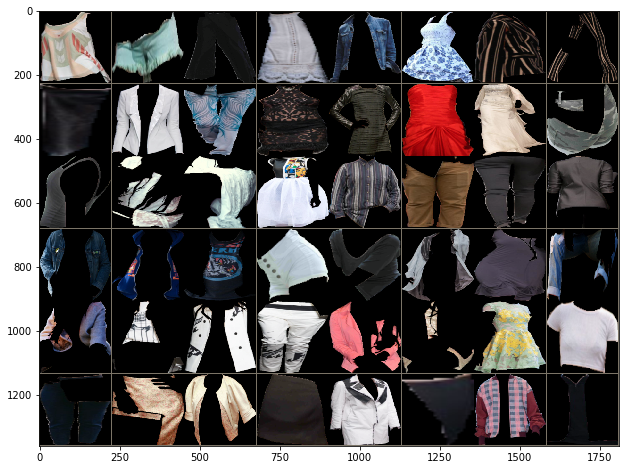

In [20]:
# Get a batch of training data
inputs, labels = next(val_iter)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)#, title=[class_names[x] for x in classes]
# plt.imshow(out, title=[class_names[x] for x in classes])

In [21]:
if use_gpu:
    inputs = inputs.to('cuda')
    labels = [label.to('cuda') for label in labels]

In [22]:
with torch.no_grad():
    outputs = model(inputs)
preds = []
for i in range(len(label_index)-1):
    _, pred = torch.max(outputs[:, label_index[i]:label_index[i+1]], 1)
    preds.append(pred)

In [23]:
corrects = torch.zeros_like(preds[0], device='cpu')
for pred, label in zip(preds, labels):
    corrects += (pred==label).to('cpu').long()
torch.sum(corrects>len(preds)).item()

0

## visualize

In [19]:
def visualize_model(model, label_index, num_images=8):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs = inputs.to('cuda') #, labels, Variable(labels.cuda())

        outputs = model(inputs)
        preds = []
        for i in range(len(label_index)-1):
            _, pred = torch.max(outputs.data[:, label_index[i]:label_index[i+1]], 1)
            preds.append(pred)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
#             ax.set_title('predicted: {}_label:{}'.format(class_names[preds[j]],class_names[labels[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return preds

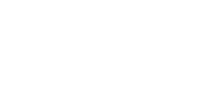

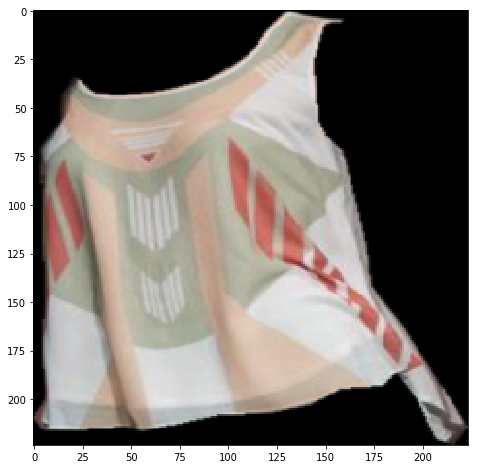

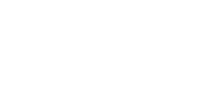

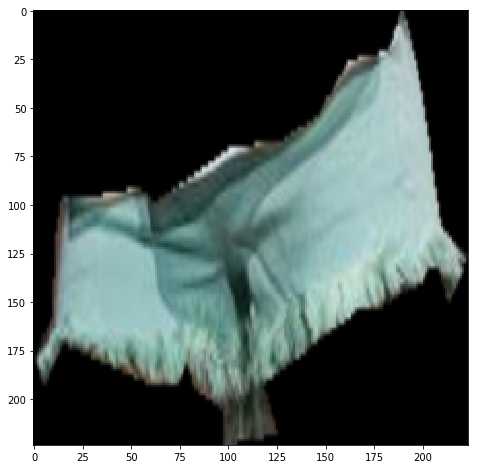

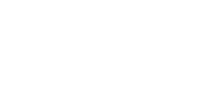

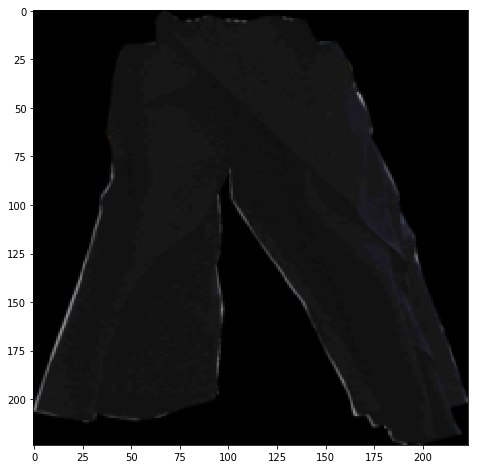

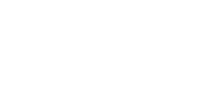

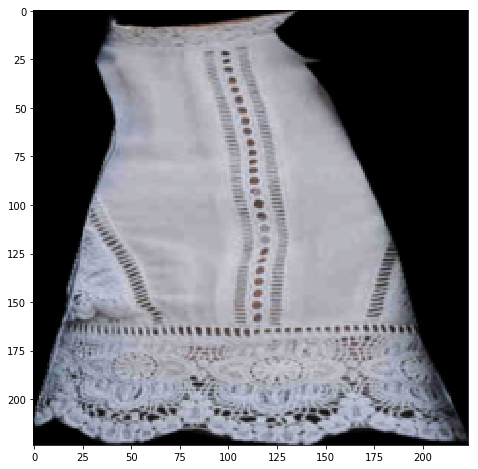

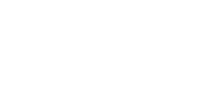

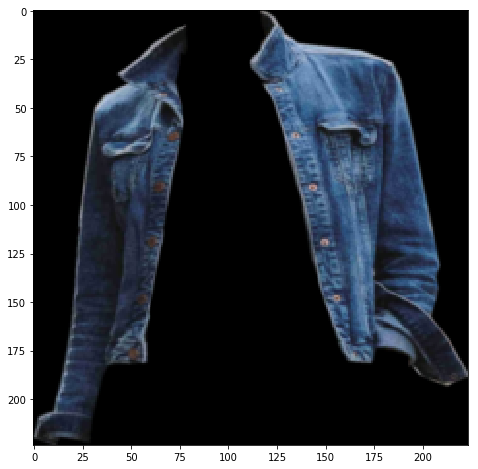

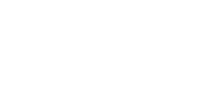

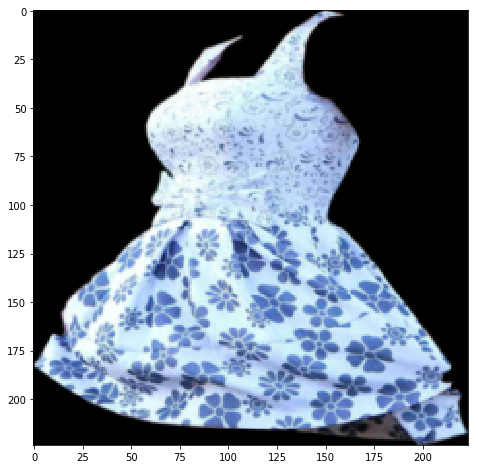

In [21]:
preds = visualize_model(model_ft, label_index, num_images=6)

In [24]:
pred = preds[0]
pred

tensor([ 4,  0, 11, 11,  0,  0, 11, 11, 11, 11, 11, 11, 11,  0,  0, 11, 11,  4,
        11,  0, 11, 11, 11, 11, 11, 11,  4, 11, 11, 11, 11, 11, 11, 11,  4, 11,
        11, 11,  0, 11, 11, 11, 11, 11, 11,  0, 11, 11, 11, 11, 11, 11,  0,  0,
        11, 11, 11, 11, 11,  0, 11, 11, 11, 11], device='cuda:0')

In [26]:
pred[0].item()

4

In [15]:
model_ft = train_model(model, criterions, optimizer_ft, lr_scheduler, label_index,
                       num_epochs=30)

  0%|          | 0/154 [00:00<?, ?it/s]

Epoch 0/29
----------


100%|██████████| 154/154 [18:17<00:00,  7.13s/it]


train Loss: 11.7192 Acc: 10.0000


100%|██████████| 28/28 [03:06<00:00,  6.66s/it]


val Loss: 9.9338 Acc: 10.0000


  0%|          | 0/154 [00:00<?, ?it/s]


Epoch 1/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 9.3152 Acc: 10.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 11.4449 Acc: 10.0000

Epoch 2/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 8.4972 Acc: 11.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 8.3305 Acc: 11.0000

Epoch 3/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 6.7779 Acc: 11.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 7.5832 Acc: 11.0000

Epoch 4/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 6.0103 Acc: 11.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 7.8008 Acc: 11.0000

Epoch 5/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 6.2033 Acc: 11.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 8.5896 Acc: 11.0000

Epoch 6/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 5.7928 Acc: 11.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 8.0846 Acc: 11.0000

Epoch 7/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 4.6231 Acc: 12.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 7.8678 Acc: 11.0000

Epoch 8/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 4.1227 Acc: 12.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 8.0466 Acc: 11.0000

Epoch 9/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 4.1362 Acc: 12.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 8.8567 Acc: 11.0000

Epoch 10/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 3.8589 Acc: 12.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 8.4322 Acc: 11.0000

Epoch 11/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 3.1440 Acc: 12.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 8.4988 Acc: 11.0000

Epoch 12/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 2.8423 Acc: 13.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 8.6645 Acc: 11.0000

Epoch 13/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 2.8454 Acc: 13.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 8.8500 Acc: 11.0000

Epoch 14/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 2.6162 Acc: 13.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 8.9851 Acc: 11.0000

Epoch 15/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 2.2966 Acc: 13.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 9.0206 Acc: 11.0000

Epoch 16/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 2.1542 Acc: 13.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 9.1694 Acc: 11.0000

Epoch 17/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 2.1341 Acc: 13.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 9.2949 Acc: 11.0000

Epoch 18/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 1.9930 Acc: 13.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 9.3899 Acc: 11.0000

Epoch 19/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 1.8822 Acc: 13.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 9.3710 Acc: 11.0000

Epoch 20/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 1.7903 Acc: 13.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 9.4459 Acc: 11.0000

Epoch 21/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 1.7815 Acc: 13.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 9.5324 Acc: 11.0000

Epoch 22/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 1.7020 Acc: 13.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 9.6560 Acc: 11.0000

Epoch 23/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 1.6482 Acc: 13.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 9.6284 Acc: 11.0000

Epoch 24/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 1.5764 Acc: 13.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 9.6830 Acc: 11.0000

Epoch 25/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 1.5548 Acc: 13.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 9.7729 Acc: 11.0000

Epoch 26/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 1.5252 Acc: 13.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 9.7948 Acc: 11.0000

Epoch 27/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 1.4817 Acc: 13.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 9.8155 Acc: 11.0000

Epoch 28/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 1.4523 Acc: 13.0000


  0%|          | 0/154 [00:00<?, ?it/s]

val Loss: 9.8052 Acc: 11.0000

Epoch 29/29
----------


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 1.4279 Acc: 13.0000


100%|██████████| 28/28 [03:02<00:00,  6.51s/it]


val Loss: 9.8356 Acc: 11.0000

Training complete in 588m 21s
Best val Acc: 11.000000
